In [25]:
%env CUDA_VISIBLE_DEVICES = 7

env: CUDA_VISIBLE_DEVICES=7


In [26]:
import sys
sys.path.append("..")
import jax
from jax import numpy as jnp
import jax_cfd.base as cfd
from jax_cfd.base import grids
from jax_cfd.spectral import equations as spectral_equations
from jax_cfd.spectral import time_stepping
import matplotlib.pyplot as plt
from einops import rearrange
from jax import image
from math import floor

In [27]:
def get_grid(resolution, domain=(0, 2*jnp.pi)):
  return grids.Grid((resolution,), domain=(domain,))


def get_zeros_initial_condition(grid, dtype=jnp.complex64):
  n, = grid.shape
  return jnp.zeros(n // 2 + 1, dtype=dtype)


def get_sine_initial_condition(grid):
  xs, = grid.axes(offset=(0,))
  return jnp.fft.rfft(jnp.sin(xs))

In [28]:
size = 256
outer_steps = 1024

length = 20. * jnp.pi
grid = cfd.grids.Grid((size,), domain=((0, length),))
dx, = grid.step
dt = 0.2
smooth = True

step_fn = time_stepping.backward_forward_euler(
    spectral_equations.KuramotoSivashinsky(grid, smooth=smooth), dt)
rollout_fn = jax.jit(cfd.funcutils.trajectory(step_fn, outer_steps))
xs, = grid.axes()

real_space_trajectory = []
num_of_traj = 1000
u0 = 0.
key = jax.random.key(0)
for i in [-4, -3, -2, -1, 1, 2, 3, 4]:
    subkey1, subkey2, key = jax.random.split(key, 3)
    u0 += jax.random.uniform(subkey1, (num_of_traj, 1)) * jnp.sin(
        (2*i*jnp.pi / length) * xs + length / size * jax.random.uniform(subkey2, (num_of_traj, 1))
    )
u0 = jax.lax.stop_gradient(u0.reshape(*u0.shape))

for v0 in u0:
    v0 = jnp.fft.rfft(v0)
    _, trajectory = jax.device_get(rollout_fn(v0))

    real_space_trajectory.append(jnp.fft.irfft(trajectory).real)
real_space_trajectory = jnp.array(real_space_trajectory)

In [29]:
jnp.unique(jnp.argwhere(jnp.isnan(real_space_trajectory))[:, 0])

Array([ 37, 107, 474, 499, 619, 703, 737], dtype=int32)

In [30]:
real_space_trajectory.shape

(1000, 1024, 256)

In [31]:
mask = jnp.ones(real_space_trajectory.shape[0], dtype=bool)
mask = mask.at[jnp.unique(jnp.argwhere(jnp.isnan(real_space_trajectory))[:, 0])].set(False)
fil_rst =  real_space_trajectory[mask]

In [106]:
# small_traj = rearrange(real_space_trajectory, "traj (c t) s -> (traj c) t s", c=4) # for different ic dataset
# b, t, s = small_traj.shape
# small_traj = image.resize(small_traj, (b, 32, 32), "cubic")
# small_traj_cont = rearrange(small_traj, "(traj c) t s -> traj (c t) s", c=4)
# small_traj_cont = jnp.concat(small_traj_cont, axis=0)

In [32]:
# stride = 256
# samples = floor((8255-256)/stride + 1)

In [33]:
# small_traj = jnp.array([real_space_trajectory[0, stride*i:stride*i+256] for i in range(samples)]) #for correlated traj
# b, t, s = small_traj.shape
# small_traj = image.resize(small_traj, (b, 32, 32), "cubic")
# small_traj_cont = jnp.concat(small_traj[::256//stride])#jnp.concat([jnp.concat(small_traj[::32]), small_traj[-1, 96:]])

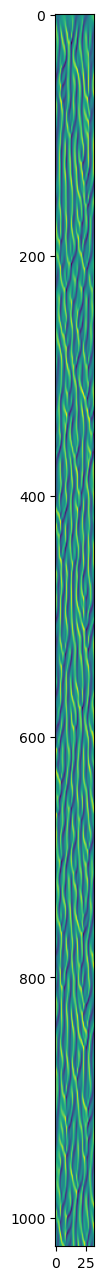

In [35]:
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,16))
# axes.imshow(small_traj_cont)

In [64]:
# small_traj.shape

(32, 32, 32)

In [36]:
# small_traj = rearrange(real_space_trajectory, "traj (c t) s -> (traj c) t s", c=4)
# b, t, s = small_traj.shape
# small_traj = image.resize(small_traj, (b, 32, 32), "cubic")

In [32]:
jnp.save("/home/meet/FlowMatchingTests/conditional-flow-matching/neural_operator/data/ks_high_res_long", fil_rst[:, 128:])